Perform an area-wide correlation analysis of vehicle emissions.
Determine spatial variation, and variation based on other factors, such as land use of surrounding areas, population, network classification (road type), weather, etc.
Correlate the provided emissions data with other provided datasets.

### Global imports

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [5]:
ls

README.md                   scripts/
data/                       snapshot_to_building.ipynb
q2.ipynb


In [6]:
links=gpd.read_file("data/road_network/RoadNetwork.geojson")
links = links.rename(columns={'LINKID': 'linkID'})

In [7]:
emissions=pd.read_csv('data/emissions_data/Emissions/2017-01-09_07_energy.csv')
emissions

,hour,linkID,pollutantID,emrate,emquant
0,7,2,91,8.210320e+05,30751.423168
1,7,3,91,8.210320e+05,34707.868976
2,7,4,91,8.210320e+05,12255.879647
3,7,5,91,8.210320e+05,8506.983011
4,7,7,91,8.210320e+05,7038.390622
...,...,...,...,...,...
1156,7,2583,91,0.000000e+00,0.000000
1157,7,2585,91,8.927560e+05,4160.496323
1158,7,2586,91,0.000000e+00,0.000000
1159,7,2591,91,2.400668e+06,11187.795453


In [9]:
links['linkID']=links['linkID'].astype(float)
emissions['linkID']=emissions['linkID'].astype(float)

### Merge road network and emission dataset

In [10]:
emission_links=links.merge(emissions, on='linkID')

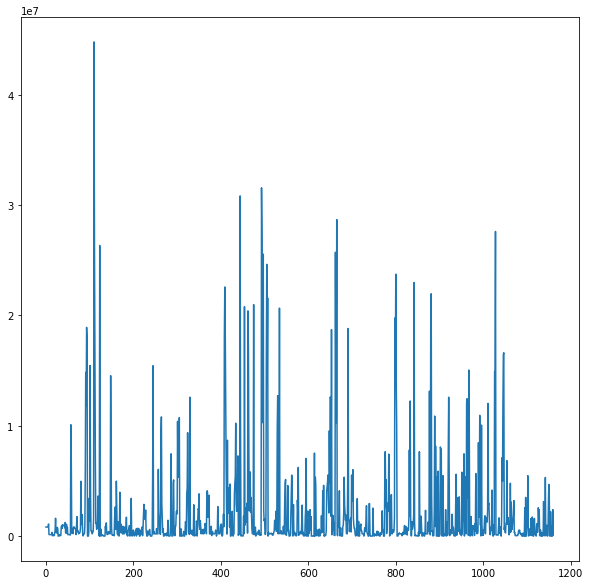

In [11]:
fig,ax = plt.subplots(figsize = (10,10))
emission_links['emrate'].plot(ax=ax)
plt.show()

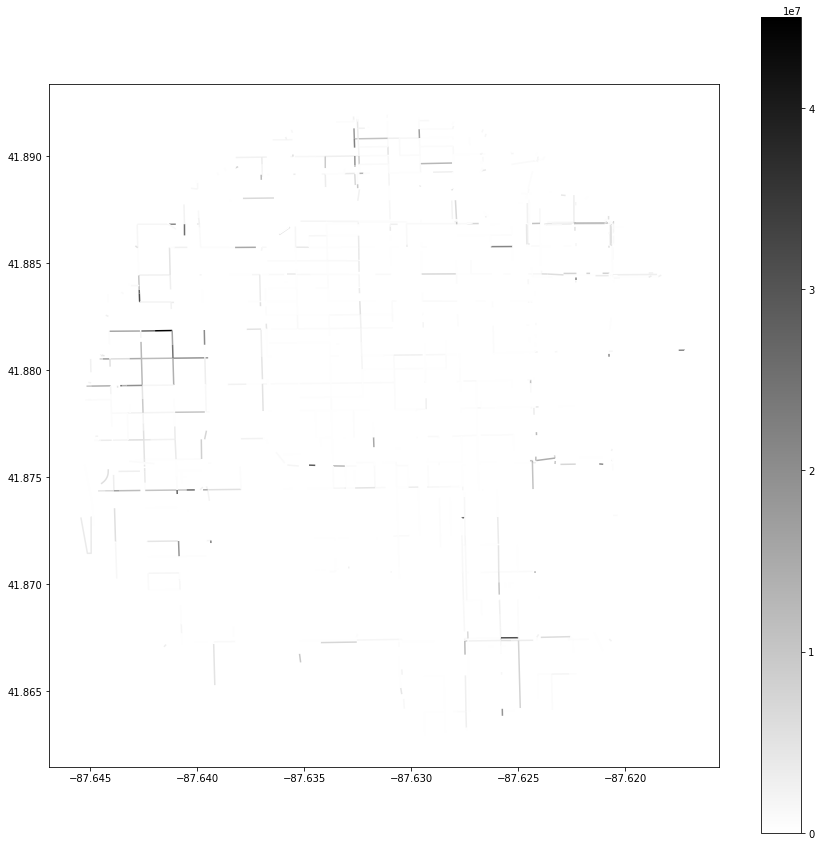

In [29]:
fig,ax = plt.subplots(figsize = (15,15))
emission_links.plot(ax=ax, column='emrate',cmap='binary',vmin=-1, vmax=45000000)
fig = ax.get_figure()
sm = plt.cm.ScalarMappable(cmap='binary', norm=plt.Normalize(vmin=-1, vmax=45000000))
fig.colorbar(sm, ax=ax)

### Scaling plan

Import and concatenate all emissions data, group by link ID and plot over time (daily and beyond).

Get weather data for each emissions snapshot

Census data - connect tracts with links

Road type - which dataset is this